In [1]:
%matplotlib inline
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pandas as pd
import corner
import astropy
import astropy.units as u

In [2]:
from astropy import constants as const

In [3]:
H0=70.* u.km / u.s / u.Mpc
c=const.c.to('km/s')
a=c/H0
a1=a.value
n=10000

In [4]:
zz= np.random.uniform(0.01, 10., n)
e=np.random.normal(0.1,0.5, n)
#(Vigoureux):
m=25+5*np.log10(a1)+5*np.log10((zz+1)*np.log(zz+1))+e
#m=a1*np.log(z+1)+e
#the best-fit function to represent the observational z/extinction-corrected distance moduli (μ) data set(Marosi):
#m=44.109*zz**(0.0598)+e
#m=a1*(((zz+1)**2) -1)/(((zz+1)**2) +1) + e
#m=2*a1*(1-(1+zz)**(-1/2))+e

In [5]:
print zz

[1.43944628 4.61385514 8.55538049 ... 0.80751762 9.68442285 3.94112499]


In [6]:
print m

[44.78114074 47.01071851 49.84239315 ... 44.09752    50.87860052
 47.75190827]


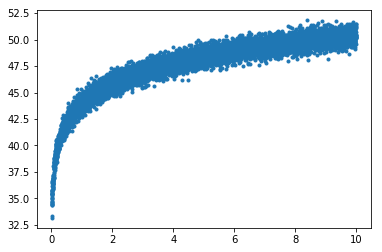

In [7]:
plt.plot(zz, m, '.')

In [8]:
dat= {'zz':np.random.uniform(0., 1., n),
      'e':np.random.normal(0.2,0.1, n),
      'm':44.109*zz**(0.0598)+e }
df = pd.DataFrame(data=dat)

In [9]:
data=np.sort(df.T, axis=0)
zs = df.zz
mm = df.m
dm = df.e

In [10]:
from astropy.cosmology import wCDM

In [11]:
def w(z) :
    wz=w0
    return wz

In [12]:
def DM(z,H0,Om,Ode,w):
    cosmo = wCDM(H0=H0* u.km / u.s / u.Mpc, Om0=Om,Ode0=Ode,w0=w)
    DL=cosmo.luminosity_distance(z)
    mag=5*np.log10((DL/(10*u.pc)).decompose())
    return mag

In [13]:
p = lmfit.Parameters()
p.add_many(('Om',0.3,True,0.,2.),('H0',70.0,True,50.,100.),('Ode',0.7,True,0.,2.),('w',-1.0,True,-2.,2.))

def residual(p):
    v = p.valuesdict()
    return (DM(zs,v['H0'],v['Om'],v['Ode'],v['w'])-mm)/dm

In [14]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


KeyboardInterrupt: 

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 428
    # data points      = 1527
    # variables        = 4
    chi-square         = 1.8974e+08
    reduced chi-square = 124585.103
    Akaike info crit   = 17919.8953
    Bayesian info crit = 17941.2196
[[Variables]]
    Om:   4.0212e-13 (init = 0.3)
    H0:   50.0000000 (init = 70)
    Ode:  2.00000000 (init = 0.7)
    w:   -2.00000000 (init = -1)


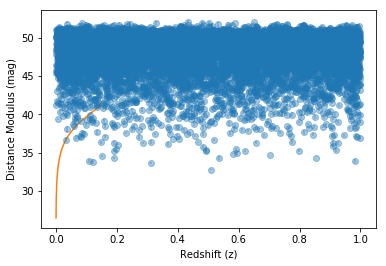

In [31]:
s = (zs.sort_values()).index
plt.errorbar(zs[s],mm[s],yerr=dm[s],fmt='o',alpha=0.4)
bestOm = mi.params.valuesdict()['Om']
bestH0 = mi.params.valuesdict()['H0']
bestOde= mi.params.valuesdict()['Ode']
bestw0 = mi.params.valuesdict()['w']
plt.plot(zs[s],DM(zs[s],bestH0,bestOm,bestOde,bestw0))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mag)')
lmfit.report_fit(mi)

In [ ]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500, thin=1,
                         params=p, is_weighted=True)

In [ ]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))